In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys
import datetime
import collections

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from __future__ import print_function, division

import numpy as np

import hosts
import targeting

from astropy import units as u
from astropy import constants as cnst
from astropy.coordinates import *
from astropy import table
from astropy.visualization import hist as ahist
from astropy.io import fits
from astropy import convolution

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)

In [4]:
from urllib2 import urlopen
import bs4 # for parsing html in the HSLA

In [5]:
def add_coord_to_tab(tab, raname='RA', decname='Dec', unit=u.deg, coocolname='skycoord'):
    coo = SkyCoord(ra=tab[raname], dec=tab[decname], unit=unit, frame='icrs')
    tab[coocolname] = coo
    return coo

In [6]:
imagelist_kwargs={}
# this supresses actually showing the imagelists - comment it out to get the imagelists to pop up
imagelist_kwargs['url'] = None

# Load the SAGA datasets 

## First load the flag0/host lists

In [7]:
export_url_templ = 'https://docs.google.com/spreadsheets/d/{id}/export?format=csv&id={id}&gid={gid}'
base_id = '1b3k2eyFjHFDtmHce1xi6JKuj3ATOWYduTBFftx5oPp8'
flag0_gid = '448084634'
nsats_gid = '271797930'


tab_flag0 = table.Table.read(export_url_templ.format(id=base_id, gid=flag0_gid), format='csv')
tab_nsats0 = table.Table.read(export_url_templ.format(id=base_id, gid=nsats_gid), format='csv')

In [8]:
print(len(tab_flag0))
tab_flag0[:5].show_in_notebook()

74


NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,u-r,sersic_n,stellar_mass,N_sats_all,N_sats_removed,N_sats_rem1and2,N_SDSS_sats,N_sats_total
145729,224.594,-1.09102,53499,1922.0,28.4038,11.9155,11.457,11.0653,9.49,7.693,0.019,0,-24.5739,-20.3514,48.4266,3.55266,12.164,0.983605,2.6946,2.82806,19800000000.0,1,1,1,1,1
150887,348.683,4.53406,70795,2689.0,37.019,11.9764,11.6247,11.3038,10.57,8.327,0.013,0,-24.5151,-20.8657,-50.6545,5.73166,10.189,0.98742,1.90022,0.777359,25100000000.0,0,0,0,0,0
140594,180.098,-1.10008,37845,1465.0,23.2487,11.1116,10.7406,10.4707,9.35,7.321,0.015,0,-24.511,-20.7204,59.2146,2.29212,12.669,0.985217,2.05631,1.7545,20600000000.0,2,1,2,1,1
142722,194.863,14.1712,44600,1988.0,30.027,11.4723,11.0534,10.7367,9.93,7.907,0.016,0,-24.4806,-20.9153,76.9088,3.38499,10.768,0.987676,2.70741,2.18747,35000000000.0,5,2,2,2,2
150578,346.236,12.3229,70419,2381.0,33.313,11.5503,11.1597,10.903,9.89,8.162,0.021,0,-24.4511,-21.0628,-42.8417,9.44227,14.017,0.987084,2.07284,2.01064,34400000000.0,0,0,0,0,0


In [9]:
print(len(tab_nsats0))
tab_nsats0[:5].show_in_notebook()

74


NSAID,RA,Dec,N_sats_all,N_sats_removed,N_sats_rem1and2,N_SDSS_sats,N_sats_total
145729,224.594,-1.09102,1,1,1,1,1
150887,348.683,4.53406,0,0,0,0,0
140594,180.098,-1.10008,2,1,2,1,1
142722,194.863,14.1712,5,2,2,2,2
150578,346.236,12.3229,0,0,0,0,0


In [10]:
# double-check that the above two are aligned
assert np.all(tab_flag0['NSAID']==tab_nsats0['NSAID'])

### Combine the two together 

In [11]:
tab_hosts = table.join(tab_flag0, tab_nsats0[[nm for nm in tab_nsats0.colnames if nm.startswith('N')]], 'NSAID')
add_coord_to_tab(tab_hosts)

print(len(tab_hosts))
tab_hosts[:5].show_in_notebook()

74


NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,u-r,sersic_n,stellar_mass,N_sats_all_1,N_sats_removed_1,N_sats_rem1and2_1,N_SDSS_sats_1,N_sats_total_1,N_sats_all_2,N_sats_removed_2,N_sats_rem1and2_2,N_SDSS_sats_2,N_sats_total_2,skycoord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
32,145.514,0.336452,27723,1912.35,30.0374,11.8626,11.603,11.4285,10.53,8.848,0.036,0,-23.5403,-20.5257,37.2791,8.62942,13.304,0.974112,1.63536,1.3137,16800000000.0,1,1,1,1,1,1,1,1,1,1,"145.514,0.336452"
13927,180.676,1.9768,38031,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,2.43461,3.12889,19800000000.0,0,0,0,0,0,0,0,0,0,0,"180.676,1.9768"
16235,139.416,52.993,26246,2274.04,36.2141,12.9972,12.5874,12.277,14.99,9.406,0.02,0,-23.3884,-19.7972,43.0944,13.055,12.621,0.972638,2.35828,1.49728,12000000000.0,8,3,3,3,3,8,3,3,3,3,"139.416,52.993"
16559,154.888,58.2058,30176,2099.41,34.4951,12.3762,11.8854,11.586,11.85,9.469,0.031,0,-23.2198,-20.3126,49.2187,8.48479,11.148,0.98321,1.98864,1.75007,19100000000.0,4,2,3,3,3,4,2,3,3,3,"154.888,58.2058"
33446,123.241,36.2546,23028,2469.7,37.7379,12.3668,12.0137,11.739,11.77,9.407,0.032,0,-23.4769,-20.5171,31.306,14.5285,12.875,0.972509,2.04922,2.13367,21200000000.0,2,2,2,2,2,2,2,2,2,2,"123.241,36.2546"


In [12]:
# just in case lets save out a local copy
#fn = 'hosts_flag0_tab_{}.ecsv'.format(datetime.datetime.now().strftime('%F'))
#print('writing', fn)
#tab_hosts.write(fn, format='ascii.ecsv')

#or load with
#tab_hosts = table.Table.read(fn, format='ascii.ecsv')

## And also load the sats list 

In [13]:
tab_specs = table.Table.read('SAGADropbox/data/saga_spectra_clean.fits.gz')
add_coord_to_tab(tab_specs, raname='RA', decname='DEC')

tab_sats = tab_specs[(tab_specs['ZQUALITY']>=3)&(tab_specs['REMOVE']==-1)&(tab_specs['SATS']==1)]

print(len(tab_specs), len(tab_sats))
tab_sats[:5].show_in_notebook()

48238 137


OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,SATURATED,BAD_COUNTS_ERROR,BINNED1,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,Column1,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS_SGQ,SPEC_CLASS_AE,SPECOBJID,SPEC_REPEAT,skycoord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
1237655693015056396,224.532617519,-1.31259609568,3,GALAXY,35253360398352,262144,0,268435456,17.3497,16.089,15.4546,15.1464,14.9615,0.0416732,0.00498512,0.00534471,0.00545955,0.0135447,0.0416732,0.00498512,0.00534471,0.00545955,0.0135447,0.32708,0.240662,0.174548,0.132355,0.0938412,17.1418,15.8741,15.3876,15.0828,14.9173,12.9075,13.4682,13.1628,13.8231,13.8238,0.738636,0.710056,0.803463,0.78797,0.894669,21.15,3.11296,24.4211,0.411017,23.5287,0.513989,23.8198,0.408222,24.1926,1.04576,0.449992,0.465957,0.446009,0.475622,0.467311,17.477,0.0415375,16.0842,0.00498177,15.5622,0.00534471,15.1929,0.00545646,15.0088,0.0135404,21.1691,0.0788425,19.6741,0.0184681,19.4228,0.0195905,19.0933,0.019701,18.8251,0.037165,20.6698,0.0618124,19.3683,0.0111833,18.7532,0.0087296,18.4167,0.00977192,18.174,0.0217943,0.0,0.0,0.0,0.0,0.0,0.0862015,-0.015842,0.139541,-0.0327954,0.14517,-0.0385242,0.135794,-0.034536,0.133919,-0.0334079,0.508928,8.21412,149.518,0.479386,8.81146,151.674,0.473689,8.55776,152.901,0.487392,8.70547,151.876,0.495454,8.42529,152.167,19.5874,0.0125185,15.5622,0.00534471,8.55776,6.02391,13.3899,15.5966,22.2194214691,21.4913916271,15.174,9999.0,15.71,0.248,14.45,9999.0,0.0064927,2.15047e-05,0,0.067474,0.016437,-1.0,-1.0,-1.0,-1.0,224.594,-1.09102,28.4038,1922.0,-24.5738822299,145729,0,,13.7934861167,113.96603527,35536,1,0.559135409723,0.691219228277,-1,NSA,sdss,4,,,1.23765569302e+18,NSA,"224.532617519,-1.31259609568"
1237648702984683605,225.005401226,-1.09130226734,3,GALAXY,1161121054724696,0,0,268435456,16.0611,15.3154,14.9987,14.8723,14.7438,0.00790307,0.00274512,0.00320407,0.00445661,0.00904204,0.00790307,0.00274512,0.00320407,0.00445661,0.00904204,0.327712,0.241128,0.174886,0.132611,0.0940226,15.997,15.1689,14.8268,14.7113,14.6349,40.986,12.9685,13.7948,14.3383,13.7471,1.52479,0.171283,0.158666,0.162538,0.28877,10.7435,0.29789,14.1078,0.139925,15.0666,0.189859,16.1199,0.217477,19.1789,0.55349,0.763178,0.837018,0.889757,0.903721,0.889412,16.1489,0.00772101,15.3572,0.00280809,14.9363,0.00327976,14.7643,0.00451928,14.6683,0.00921106,18.9691,0.0220671,18.7247,0.0217491,18.3088,0.0183036,18.6214,0.0184466,18.4012,0.0271797,18.6917,0.0133083,18.1511,0.00473336,17.9322,0.00489516,17.876,0.00606622,1

### Also figure out which are the saga hosts

In [14]:
saga_hosts = hosts.get_saga_hosts_from_google()
saga_hosts_nsaids = {host.nsaid: host for host in saga_hosts}

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [15]:
saga_names = []
for nsaid in tab_hosts['NSAID']:
    if nsaid in saga_hosts_nsaids:
        saga_names.append(saga_hosts_nsaids[nsaid].name)
    else:
        saga_names.append('')
tab_hosts['SAGA_name'] = saga_names

# Now collect Jason T's QSO datasets 

In [16]:
tab_qso = table.Table(table.Table.read('catalogs/dr7qso_galex.fits'), masked=True)
add_coord_to_tab(tab_qso, raname='RA', decname='DEC')

tab_qso19 = tab_qso[(0<tab_qso['FUV_MAG'])&(tab_qso['FUV_MAG']<19)]

print(len(tab_qso), len(tab_qso19))
tab_qso19[:5].show_in_notebook()

105811 2627


SDSSNAME,RA,DEC,Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,A_U,LOGNHI,FIRSTMAG,FIRST_SN,FIRST_SEP,LG_RASS_RATE,RASS_SN,RASS_SEP,TWOMASSMAG_J,TWOMASSMAGERR_J,TWOMASSMAG_H,TWOMASSMAGERR_H,TWOMASSMAG_K,TWOMASSMAGERR_K,TWOMASS_SEP,M_I,DELTA_G_I,MORPHOLOGY,SCIENCEPRIMARY,MODE,UNIFORM,BESTPRIMTARGET,TS_B_QSO,TS_B_HIZ,TS_B_FIRST,TS_B_ROSAT,TS_B_SERENDIP,TS_B_STAR,TS_B_GAL,RUN_BEST,MJD_BEST,MJD_SPEC,PLATE,FIBERID,RERUN_BEST,CAMCOL_BEST,FIELD_BEST,OBJ_BEST,TARGPRIMTARGET,TS_T_QSO,TS_T_HIZ,TS_T_FIRST,TS_T_ROSAT,TS_T_SERENDIP,TS_T_STAR,TS_T_GAL,T_PSFMAG_U,T_PSFMAGERR_U,T_PSFMAG_G,T_PSFMAGERR_G,T_PSFMAG_R,T_PSFMAGERR_R,T_PSFMAG_I,T_PSFMAGERR_I,T_PSFMAG_Z,T_PSFMAGERR_Z,BESTOBJID,SPECOBJID,OBJECT_NAME,GALEX_OBJID,GALEX_RA,GALEX_DEC,GALEX_SEP,GALEX_TYPE,GALEX_BAND,NUV_FLUX,NUV_FLUXERR,FUV_FLUX,FUV_FLUXERR,NUV_MAG,NUV_MAGERR,FUV_MAG,FUV_MAGERR,GALEX_NOBJ,skycoord
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg"
000011.96+000225.3,0.0498390011489,0.0403649993241,0.4789,18.228,0.027,17.934,0.02,17.995,0.019,17.934,0.014,17.873,0.029,0.161,20.502,0.0,0.0,0.0,-1.66,2.157,2.04,16.651,0.136,15.82,0.149,14.821,0.111,0.209,-24.068,-0.146,0,1,1,0,134224898,1,0,0,1,0,0,0,3325,52522,51791,387,200,41,4,108,19,134224900,1,0,0,1,0,0,0,17.835,0.011,17.58,0.004,17.695,0.005,17.646,0.006,17.66,0.024,588015509269381139,109153257477111808,LBQS 2357-0014,6381013764764861047,0.0498250763621,0.0404867856438,0.441287278442,1,3,198.586,9.1663,134.936,12.7213,18.1527,0.0501274,18.5776,0.102384,2,"0.0498390011489,0.0403649993241"
000110.97-105247.4,0.295722007751,-10.8798570633,0.5282,17.999,0.022,17.674,0.026,17.646,0.016,17.484,0.024,17.512,0.028,0.183,20.439,0.0,0.0,0.0,-9.0,0.0,0.0,16.467,0.095,15.614,0.112,14.916,0.108,0.155,-24.764,0.017,0,1,1,0,1048578,1,0,0,0,1,0,0,1740,51814,52143,650,126,40,1,24,71,1048580,1,0,0,0,1,0,0,17.95,0.018,17.65,0.018,17.658,0.018,17.506,0.018,17.501,0.021,587727225153388615,183182687870124032,SDSS J000110.97-105247.4,2435007175675876212,0.295777766876,-10.8798445586,0.20219960592,0,3,226.309,2.69221,141.979,3.5783,18.0108,0.0129192,18.5223,0.0273704,2,"0.295722007751,-10.8798570633"
000410.80-104527.1,1.04502701759,-10.7575368881,0.2397,18.125,0.025,17.951,0.02,17.681,0.027,17.531,0.013,17.432,0.021,0.192,20.444,0.0,0.0,0.0,-1.352,3.3,7.26,16.097,0.087,15.181,0.098,14.368,0.072,0.091,-22.829,-0.221,0,1,1,0,7170,1,0,0,1,0,0,0,1729,51813,52143,650,18,40,2,90,17,7172,1,0,0,1,0,0,0,18.096,0.018,17.929,0.018,17.693,0.017,17.522,0.013,17.409,0.018,587727178449944593,183182687417139200,SDSS J000410.80-104527.1,6380415564941101376,1.04514692228,-10.7574263506,0.581539875822,1,3,101.836,6.96794,113.507,11.1903,18.8778,0.0743079,18.7653,0.107066,2,"1.04502701759,-10.7575368881"
000548.24-084808.4,1.45100700855,-8.80234718323,1.1906,17.968,0.034,17.874,0.035,17.623,0.019,17.636,0.022,17.715,0.027,0.172,20.487,0.0,0.0,0.0,-9.0,0.0,0.0,17.126,0.259,16.657,0.296,0.0,0.0,0.019,-26.577,-0.057,0,1,1,0,2,1,0,0,0,0,0,0,1740,51814,52141,651,328,40,6,32,7,4,1,0,0,0,0,0,0,17.92,0.014,17.892,0.014,17.663,0.007,17.629,0.018,17.705,0.025,587727227838267399,183464155104149504,SDSS J000548.24-084808.4,6380415545613749966,1.45083866643,-8.8023579513,0.600147137654,1,3,221.995,7.46231,98.0474,8.59181,18.0317,0.0365057,18.9243,0.0951652,2,"1.45100700855,-8.80234718323"
000557.23+002837.7,1.48849904537,0.477142989635,0.2596,18.587,0.024,18.566,0.024,18.41,0.023,18.369,0.027,17.857,0.049,0.282,20.479,0.0,0.0,0.0,-9.0,0.0,0.0,16.691,0.149,15.911,0.139,15.121,0.106,0.125,-22.215,-0.202,0,1,1,0,3,1,1,0,0,0,0,0,3325,52522,51793,388,385,41,5,118,37,4,1,0,0,0,0,0,0,18.517,0.018,18.493,0.008,18.303,0.011,18.173,0.014,17.795,0.023,588015509806907429,109434741819703296,LBQS 0003+0011,6381013763691121033,1.48841064477,0.477408398602,1.00707414717,1,3,98.6517,6.81361,123.574,11.0682,18.9123,0.0750071,18.6731,0.0972697,1,"1.48849904537,0.477142989635"


In [17]:
with fits.open('https://archive.stsci.edu/missions/hlsp/uvqs/hlsp_uvqs_multi_multi_all_multi_v1_redshifts.fits', 
              cache=True) as f:
    uvqs_tab = table.Table.read(f)
add_coord_to_tab(uvqs_tab, raname='RA', decname='DEC')

# JT recommended this cut
uvqs_good_tab = uvqs_tab[uvqs_tab['Z_QUAL']>=3]

print(len(uvqs_good_tab))
uvqs_good_tab[:5].show_in_notebook()

1121


DEC,FUV,NAME,NUV,OBJ,OBJ_IDX,OBJ_IDX2,OBSV,OBS_DATE,RA,SCI_FILE,SCND_FILE,SPEC_QUAL,THETA [20],W1,W2,Z,ZASS_FIL,Z_QUAL,Z_SIG,comment,dbx_path,instr,CAND,SPEC_FILE,FINDER,skycoord
deg,,,,,,,,,deg,,,,,,,,,,,,,,,,,"deg,deg"
-20.0743611111,18.2729988098,UVQSJ000000.15-200427.7,17.9699993134,0,1,-1,LCO,Aug2014,0.000625,09aug2014/Science/sci-ccd0918.fits.gz,,3,4.39948940277 .. 0.0,13.5480003357,12.5389995575,0.290799587965,LCO_09aug2014_zassess.fits,4,0.000171106687048,,LCO/August2014,BCS,1,UVQSJ000000.15-200427.7_LCO.fits,UVQSJ000000.15-200427.7_DSS.pdf,"0.000625,-20.0743611111"
-39.2966388889,17.8244285583,UVQSJ000503.70-391747.9,17.2321929932,0,0,-1,LCO,Aug2014,1.26541666667,07aug2014/Science/sci-ccd0645.fits.gz,,3,8.0866317749 .. 0.0,12.2600002289,11.1239995956,0.652394294739,LCO_07aug2014_zassess.fits,3,0.000363261176972,,LCO/August2014,BCS,1,UVQSJ000503.70-391747.9_LCO.fits,UVQSJ000503.70-391747.9_DSS.pdf,"1.26541666667,-39.2966388889"
-26.1945833333,18.1590518951,UVQSJ000609.57-261140.5,17.5298900604,0,1,-1,LCO,Aug2014,1.539875,09aug2014/Science/sci-ccd0920.fits.gz,,3,5.21646022797 .. 0.0,13.3079996109,12.1239995956,0.648431241512,LCO_09aug2014_zassess.fits,3,0.000249826902291,,LCO/August2014,BCS,1,UVQSJ000609.57-261140.5_LCO.fits,UVQSJ000609.57-261140.5_DSS.pdf,"1.539875,-26.1945833333"
42.2796111111,18.0854568481,UVQSJ000717.69+421646.6,17.6127948761,0,0,0,Lick,Jan2015,1.82370833333,Jan_2015/Science/sci-b337.fits.gz,Jan_2015/Science/sci-r337.fits.gz,4,17.7751274109 .. 0.0,12.4420003891,11.5080003738,0.0,Lick_jan2015_zassess.fits,4,0.000228934150073,,Lick,Kast,1,UVQSJ000717.69+421646.6_Lick.fits,UVQSJ000717.69+421646.6_DSS.pdf,"1.82370833333,42.2796111111"
-63.8627222222,17.9553394318,UVQSJ000741.00-635145.8,17.4110488892,0,0,-1,LCO,Aug2014,1.92083333333,07aug2014/Science/sci-ccd0640.fits.gz,,3,4.41201686859 .. 0.0,12.6529998779,11.454000473,0.55930185318,LCO_07aug2014_zassess.fits,3,0.000405291531933,,LCO/August2014,BCS,1,UVQSJ000741.00-635145.8_LCO.fits,UVQSJ000741.00-635145.8_DSS.pdf,"1.92083333333,-63.8627222222"


# Load pre-existing COS spectra from HSLA

In [18]:
hsla_url = 'https://archive.stsci.edu/missions/hst/spectral_legacy/samples/QSOALS_sample.html'
hsla_qso_tab = table.Table.read(hsla_url, format='html')

/Users/erik/miniconda3/envs/anaconda2/lib/python2.7/site-packages/bs4/__init__.py:166: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

To get rid of this warning, change this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


In [19]:
# saved a local copy so that it can be reused later if need be
#hsla_qso_tab.write('catalogs/hsla_qsos.ecsv', format='ascii.ecsv')

# reuse with this
#hsla_qso_tab = table.Table.read('catalogs/hsla_qsos.ecsv', format='ascii.ecsv')

In [20]:
add_coord_to_tab(hsla_qso_tab, 'RA', 'DEC')
print(len(hsla_qso_tab))

hsla_qso_tab[:5].show_in_notebook()

626


Number,Target Name,RA,DEC,Nexp,Target Description,AltName,AltClass,Redshift,MAST,Median S/N,FUV M,FUV L,Download,skycoord
,,,,,,,,,,,,,,"deg,deg"
1,1ES1028+511,157.827,50.8933,10,GALAXY;BL LAC,2MASX J10311847+5053358,QSO,0.360,MAST,18.8432,--,. . .,ALL,"157.827,50.8933"
2,1ES1553+113,238.929,11.1901,21,GALAXY;BL LAC,[HB89] 1553+113,QSO,0.36,MAST,34.9253,--,. . .,ALL,"238.929,11.1901"
3,1H1613-097,243.829,-9.60369,8,ISM;CORONAL GAS;HALO,6dF J1615191-093613,G,0.064,MAST,9.50685,--,. . .,ALL,"243.829,-9.60369"
4,1H-2129-624,324.096,-62.4003,8,GALAXY;NUCLEUS;QSO;Q,2MASX J21362313-6224008,G,0.058,MAST,35.5972,--,. . .,ALL,"324.096,-62.4003"
5,1SAXJ1032.3+5051,158.067,50.8556,8,GALAXY;QSO,2MASSi J1032161+505120,QSO,0.173,MAST,9.05873,--,. . .,ALL,"158.067,50.8556"


In [21]:
# now populate the QSO tables with matches in the HSLA

def add_hsla_match(tab, hsla_sep_threshold=10*u.arcsec):
    idx, d2d, _ = tab['skycoord'].match_to_catalog_sky(hsla_qso_tab['skycoord'])
    #hsla_match_idx = -np.ones(len(idx))
    #hsla_match_idx[d2d<hsla_sep_threshold] = idx[d2d<hsla_sep_threshold]
    #tab['hsla_match_idx'] =  hsla_match_idx
    tab['hsla_match_idx'] = np.ma.masked_where(d2d>hsla_sep_threshold, idx)
    
tab_qso = table.Table(tab_qso, masked=True)
tab_qso19 = table.Table(tab_qso19, masked=True)
add_hsla_match(tab_qso)
add_hsla_match(tab_qso19)

# X-match hosts 

In [22]:
def get_host_matches(hosttab, qsotab, rvir=300*u.kpc, hsla_sep_threshold=10*u.arcsec):
    tabs = []
    for row in hosttab:
        sc = row['skycoord']
        rvirsep = (rvir/(row['distance']*u.Mpc)).decompose()*u.radian
        seps = sc.separation(qsotab['skycoord'])
        
        subtab = qsotab[seps < rvirsep]
        subtab['qso_to_host'] = seps[seps < rvirsep]
        subtab['qso_to_host_phys'] = seps[seps < rvirsep].to(u.radian).value*(row['distance']*u.Mpc).to(u.kpc)

        tabs.append(subtab)
    return tabs

In [23]:
host_matches = get_host_matches(tab_hosts, tab_qso)
host_matches19 = get_host_matches(tab_hosts, tab_qso19)

In [24]:
n19 = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<19)) for match in host_matches]
n185 = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<18.5)) for match in host_matches]
n18 = [np.sum((0<match['FUV_MAG'])&(match['FUV_MAG']<18)) for match in host_matches]

tab_hosts['n_qso_fuv_lt_19'] = n19
tab_hosts['n_qso_fuv_lt_18.5'] = n185
tab_hosts['n_qso_fuv_lt_18'] = n18

In [25]:
host_matches_uvqs = get_host_matches(tab_hosts, uvqs_good_tab)

In [26]:
n19_uvqs = [np.sum((0<match['FUV'])&(match['FUV']<19)) for match in host_matches_uvqs]
n185_uvqs = [np.sum((0<match['FUV'])&(match['FUV']<18.5)) for match in host_matches_uvqs]
n18_uvqs = [np.sum((0<match['FUV'])&(match['FUV']<18)) for match in host_matches_uvqs]

tab_hosts['n_uvqs_fuv_lt_19'] = n19_uvqs
tab_hosts['n_uvqs_fuv_lt_18.5'] = n185_uvqs
tab_hosts['n_uvqs_fuv_lt_18'] = n18_uvqs

## Some summaries of numbers for hosts 

In [27]:
tab_hosts.show_in_notebook(75)

NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,u-r,sersic_n,stellar_mass,N_sats_all_1,N_sats_removed_1,N_sats_rem1and2_1,N_SDSS_sats_1,N_sats_total_1,N_sats_all_2,N_sats_removed_2,N_sats_rem1and2_2,N_SDSS_sats_2,N_sats_total_2,skycoord,SAGA_name,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_uvqs_fuv_lt_19,n_uvqs_fuv_lt_18.5,n_uvqs_fuv_lt_18
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,
32,145.514,0.336452,27723,1912.35,30.0374,11.8626,11.603,11.4285,10.53,8.848,0.036,0,-23.5403,-20.5257,37.2791,8.62942,13.304,0.974112,1.63536,1.3137,16800000000.0,1,1,1,1,1,1,1,1,1,1,"145.514,0.336452",,0,0,0,0,0,0
13927,180.676,1.9768,38031,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,2.43461,3.12889,19800000000.0,0,0,0,0,0,0,0,0,0,0,"180.676,1.9768",Sopranos,1,1,1,0,0,0
16235,139.416,52.993,26246,2274.04,36.2141,12.9972,12.5874,12.277,14.99,9.406,0.02,0,-23.3884,-19.7972,43.0944,13.055,12.621,0.972638,2.35828,1.49728,12000000000.0,8,3,3,3,3,8,3,3,3,3,"139.416,52.993",,0,0,0,0,0,0
16559,154.888,58.2058,30176,2099.41,34.4951,12.3762,11.8854,11.586,11.85,9.469,0.031,0,-23.2198,-20.3126,49.2187,8.48479,11.148,0.98321,1.98864,1.75007,19100000000.0,4,2,3,3,3,4,2,3,3,3,"154.888,58.2058",,0,0,0,0,0,0
33446,123.241,36.2546,23028,2469.7,37.7379,12.3668,12.0137,11.739,11.77,9.407,0.032,0,-23.4769,-20.5171,31.306,14.5285,12.875,0.972509,2.04922,2.13367,21200000000.0,2,2,2,2,2,2,2,2,2,2,"123.241,36.2546",StarTrek,0,0,0,0,0,0
52773,193.841,58.3442,44025,2490.64,38.4771,12.406,12.05,11.79,11.39,9.047,0.023,0,-23.879,-20.52,58.7766,12.3121,11.077,0.986942,2.07612,1.75581,20300000000.0,0,0,0,0,0,0,0,0,0,0,"193.841,58.3442",,0,0,0,0,0,0
61945,354.131,0.297265,71883,2556.76,34.7674,12.0858,11.7031,11.4059,11.65,9.3,0.03,0,-23.4059,-20.6201,-57.1915,9.4085,12.75,0.988686,2.44616,6.0,24700000000.0,9,2,7,2,2,9,2,7,2,2,"354.131,0.297265",AnaK,0,0,0,0,0,0
63326,248.606,21.5409,58523,2936.5,41.3763,12.9283,12.5722,12.2773,--,9.588,0.027,0,-23.4958,-20.1555,39.299,15.3853,--,0.971828,1.96522,2.23754,13900000000.0,0,0,0,0,0,0,0,0,0,0,"248.606,21.5409",,0,0,0,0,0,0
69028,210.708,49.1726,50031,2012.51,31.7148,11.9989,11.5817,11.2854,11.28,8.789,0.027,0,-23.7173,-20.5074,64.0123,8.35729,10.968,0.98862,2.4304,1.78293,23000000000.0,4,3,3,3,3,4,3,3,3,3,"210.708,49.1726",,0,0,0,0,0,0


In [28]:
print('FUV<19 (JTQSO, UVQS)')
print(np.sum(tab_hosts['n_qso_fuv_lt_19']), np.sum(tab_hosts['n_uvqs_fuv_lt_19']),'\n')

print('FUV<18.5 (JTQSO, UVQS)')
print(np.sum(tab_hosts['n_qso_fuv_lt_18.5']), np.sum(tab_hosts['n_uvqs_fuv_lt_18.5']),'\n')

print('FUV<18 (JTQSO, UVQS)')
print(np.sum(tab_hosts['n_qso_fuv_lt_18']), np.sum(tab_hosts['n_uvqs_fuv_lt_18']))

FUV<19 (JTQSO, UVQS)
23 1 

FUV<18.5 (JTQSO, UVQS)
11 1 

FUV<18 (JTQSO, UVQS)
6 1


In [29]:
tab_hosts[tab_hosts['n_qso_fuv_lt_19']>0].show_in_notebook()

NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,u-r,sersic_n,stellar_mass,N_sats_all_1,N_sats_removed_1,N_sats_rem1and2_1,N_SDSS_sats_1,N_sats_total_1,N_sats_all_2,N_sats_removed_2,N_sats_rem1and2_2,N_SDSS_sats_2,N_sats_total_2,skycoord,SAGA_name,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_uvqs_fuv_lt_19,n_uvqs_fuv_lt_18.5,n_uvqs_fuv_lt_18
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,
13927,180.676,1.9768,38031,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,2.43461,3.12889,19800000000.0,0,0,0,0,0,0,0,0,0,0,"180.676,1.9768",Sopranos,1,1,1,0,0,0
85746,149.588,32.3699,28805,1451.33,25.1343,12.5439,12.2105,11.9101,11.27,8.899,0.016,0,-23.1023,-19.4575,52.3205,7.2153,--,0.978734,1.95676,0.932093,7680000000.0,1,1,1,0,1,1,1,1,0,1,"149.588,32.3699",MobyDick,3,2,2,0,0,0
94217,209.233,29.1644,49604,2373.26,34.6222,12.0542,11.6782,11.428,11.83,9.237,0.034,0,-23.4598,-20.6425,75.4319,7.6542,13.59,0.990282,2.39188,5.16674,25900000000.0,1,1,1,1,1,1,1,1,1,1,"209.233,29.1644",,1,0,0,0,0,0
135440,130.666,14.2856,24464,2060.0,32.7765,12.0386,11.635,11.3438,10.61,8.649,0.017,0,-23.9288,-20.5392,30.9871,11.5907,11.77,0.971145,2.64515,3.66924,24500000000.0,1,1,1,1,1,1,1,1,1,1,"130.666,14.2856",,1,1,0,0,0,0
135879,141.077,34.5135,26649,1687.0,27.6714,11.588,11.2183,10.9256,--,8.032,0.016,0,-24.1782,-20.6222,45.4015,9.01869,13.189,0.981817,2.58665,4.30874,26100000000.0,5,4,4,4,4,5,4,4,4,4,"141.077,34.5135",,1,1,1,0,0,0
138201,162.818,27.9751,32533,1414.0,24.2202,11.2539,10.856,10.5627,9.87,7.972,0.014,0,-23.9489,-20.667,63.4186,5.00724,9.909,0.977563,2.63738,3.98633,27500000000.0,6,5,5,5,5,6,5,5,5,5,"162.818,27.9751",,2,1,0,0,0,0
140301,177.289,27.022,36914,1798.0,28.2771,11.7576,11.4055,11.1582,10.41,8.693,0.02,0,-23.5642,-20.4996,76.1447,4.186,9.944,0.987064,2.34973,3.00455,22700000000.0,3,2,3,2,2,3,2,3,2,2,"177.289,27.022",,1,1,1,0,0,0
140594,180.098,-1.10008,37845,1465.0,23.2487,11.1116,10.7406,10.4707,9.35,7.321,0.015,0,-24.511,-20.7204,59.2146,2.29212,12.669,0.985217,2.05631,1.7545,20600000000.0,2,1,2,1,1,2,1,2,1,1,"180.098,-1.10008",Alice,1,1,1,0,0,0
142722,194.863,14.1712,44600,1988.0,30.027,11.4723,11.0534,10.7367,9.93,7.907,0.016,0,-24.4806,-20.9153,76.9088,3.38499,10.768,0.987676,2.70741,2.18747,35000000000.0,5,2,2,2,2,5,2,2,2,2,"194.863,14.1712",,1,1,0,0,0,0


In [30]:
tab_saga_hosts = tab_hosts[tab_hosts['SAGA_name']!='']

print('FUV<19 (JTQSO, UVQS)')
print(np.sum(tab_saga_hosts['n_qso_fuv_lt_19']), np.sum(tab_saga_hosts['n_uvqs_fuv_lt_19']),'\n')

print('FUV<18.5 (JTQSO, UVQS)')
print(np.sum(tab_saga_hosts['n_qso_fuv_lt_18.5']), np.sum(tab_saga_hosts['n_uvqs_fuv_lt_18.5']),'\n')

print('FUV<18 (JTQSO, UVQS)')
print(np.sum(tab_saga_hosts['n_qso_fuv_lt_18']), np.sum(tab_saga_hosts['n_uvqs_fuv_lt_18']))

FUV<19 (JTQSO, UVQS)
6 0 

FUV<18.5 (JTQSO, UVQS)
4 0 

FUV<18 (JTQSO, UVQS)
4 0


In [31]:
tab_saga_hosts[tab_saga_hosts['n_qso_fuv_lt_19']>0].show_in_notebook()

NSAID,RA,Dec,PGC#,vhelio,distance,r,i,z,I,K,K_err,flag,K_abs,r_abs,b,dist_to_group,brightest_K_nearby,SDSS_FRACGOOD,u-r,sersic_n,stellar_mass,N_sats_all_1,N_sats_removed_1,N_sats_rem1and2_1,N_SDSS_sats_1,N_sats_total_1,N_sats_all_2,N_sats_removed_2,N_sats_rem1and2_2,N_SDSS_sats_2,N_sats_total_2,skycoord,SAGA_name,n_qso_fuv_lt_19,n_qso_fuv_lt_18.5,n_qso_fuv_lt_18,n_uvqs_fuv_lt_19,n_uvqs_fuv_lt_18.5,n_uvqs_fuv_lt_18
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,
13927,180.676,1.9768,38031,1961.14,29.5168,12.0011,11.5644,11.2205,10.98,8.743,0.027,0,-23.6073,-20.3492,62.2704,3.36159,11.815,0.98222,2.43461,3.12889,19800000000.0,0,0,0,0,0,0,0,0,0,0,"180.676,1.9768",Sopranos,1,1,1,0,0,0
85746,149.588,32.3699,28805,1451.33,25.1343,12.5439,12.2105,11.9101,11.27,8.899,0.016,0,-23.1023,-19.4575,52.3205,7.2153,--,0.978734,1.95676,0.932093,7680000000.0,1,1,1,0,1,1,1,1,0,1,"149.588,32.3699",MobyDick,3,2,2,0,0,0
140594,180.098,-1.10008,37845,1465.0,23.2487,11.1116,10.7406,10.4707,9.35,7.321,0.015,0,-24.511,-20.7204,59.2146,2.29212,12.669,0.985217,2.05631,1.7545,20600000000.0,2,1,2,1,1,2,1,2,1,1,"180.098,-1.10008",Alice,1,1,1,0,0,0
165536,221.546,-0.222942,52735,1659.36,25.3928,11.856,11.4773,11.2276,11.13,8.424,0.028,0,-23.5996,-20.1676,51.1661,3.0291,11.635,0.983643,2.34484,1.32237,16600000000.0,2,1,1,1,1,2,1,1,1,1,"221.546,-0.222942",Dune,1,0,0,0,0,0


In [32]:
matches_to_stack = []
for host, matches in zip(tab_hosts, host_matches19):
    if len(matches)>0:
        matches = matches.copy()
        del matches['skycoord']
        matches['SAGA_name'] = str(host['SAGA_name'])
        matches['SAGA_NSAID'] = host['NSAID']
        matches_to_stack.append(matches)
matched_qsos = table.vstack(matches_to_stack)
matched_qsos.sort('FUV_MAG')

add_coord_to_tab(matched_qsos, 'RA', 'DEC')
#matched_qsos is used below in the planning

<SkyCoord (ICRS): (ra, dec) in deg
    [(176.99414062, 27.24981308), (149.58726501, 32.40062332),
     (149.81187439, 32.06591034), (180.63786316, 2.43326592),
     (141.42637634, 34.68572998), (180.61149597, -1.48757696),
     (130.49639893, 14.11172009), (217.41976929, 3.35718799),
     (162.81564331, 28.09086418), (195.15090942, 13.78490925),
     (215.80909729, 50.92702484), (193.81550598, 9.80721188),
     (159.18814087, 37.11702728), (217.85540771, 57.57434082),
     (149.09672546, 32.60601807), (208.47216797, 47.12096786),
     (193.53013611, 8.20126724), (208.6993866, 42.11152267),
     (209.11180115, 28.79379845), (221.69322205, -0.52883297),
     (163.19778442, 28.38617325), (222.96473694, 59.23335648),
     (217.94163513, 3.02884889)]>

In [33]:
nms = ['{:.0f}kpc_{}'.format(row['qso_to_host_phys'], row['SAGA_name'] if row['SAGA_name']!='' else row['SAGA_NSAID']) for row in matched_qsos]
print(targeting.sampled_imagelist(matched_qsos, None, None, names=nms, **imagelist_kwargs))

name ra dec
13kpc_MobyDick 149.587265015 32.4006233215
261kpc_Alice 180.611495972 -1.48757696152
258kpc_162547 193.815505981 9.80721187592
214kpc_144121 208.472167969 47.120967865
186kpc_162580 193.530136108 8.20126724243
150kpc_Dune 221.693222046 -0.52883297205
233kpc_94217 209.111801147 28.7937984467
49kpc_138201 162.815643311 28.0908641815
155kpc_165707 222.964736938 59.2333564758
107kpc_158541 159.188140869 37.1170272827
162kpc_135879 141.426376343 34.6857299805
244kpc_165082 217.941635132 3.02884888649
157kpc_MobyDick 149.81187439 32.0659103394
209kpc_MobyDick 149.096725464 32.6060180664
268kpc_144953 215.80909729 50.9270248413
194kpc_165153 217.855407715 57.5743408203
224kpc_138201 163.197784424 28.3861732483
250kpc_142722 195.150909424 13.7849092484
236kpc_Sopranos 180.637863159 2.43326592445
296kpc_144151 208.699386597 42.1115226746
171kpc_140301 176.994140625 27.2498130798
54kpc_165082 217.419769287 3.35718798637
137kpc_135440 130.496398926 14.1117200851


# X-match sats 

In [34]:
def get_sat_closest(sattab, qsotab, sorton=None):
    idx, d2d, _ = sattab['skycoord'].match_to_catalog_sky(qsotab['skycoord'], nthneighbor=1)
    tab = qsotab[idx]
    tab['match_d2d'] = d2d
    tab['match_d2d_phys'] = (d2d.radian*sattab['HOST_DIST']*u.Mpc).to(u.kpc)
    
    if sorton is not None:
        #trick to make sort work
        sorti = np.argsort(tab[sorton])
        tab = tab[sorti]
        sattab = sattab[sorti]
    return table.hstack((sattab, tab), table_names=['sat', 'qso'])

In [35]:
sat_matches = get_sat_closest(tab_sats, tab_qso19, sorton='match_d2d_phys')
sat_matches_uvqs = get_sat_closest(tab_sats, uvqs_good_tab, sorton='match_d2d_phys')

In [36]:
sat_matches['RA_sat', 'DEC_sat', 'RA_qso', 'DEC_qso', 'TELNAME', 'HOST_SAGA_NAME', 'match_d2d_phys'].show_in_notebook()

RA_sat,DEC_sat,RA_qso,DEC_qso,TELNAME,HOST_SAGA_NAME,match_d2d_phys
,,,,,,kpc
162.849821529,28.1120278164,162.815643311,28.0908641815,NSA,,15.571269356
141.506228227,34.6534021854,141.426376343,34.6857299805,NSA,,35.3521428813
162.705990064,28.0587029336,162.815643311,28.0908641815,NSA,,43.0991415677
195.105563951,13.6705858419,195.150909424,13.7849092484,NSA,,64.2071453789
162.816110258,27.8489705993,162.815643311,28.0908641815,NSA,,102.253944422
193.556579042,8.3577808181,193.530136108,8.20126724243,NSA,,110.849879259
217.266218915,3.14899055549,217.419769287,3.35718798637,NSA,,112.425049336
217.818940474,3.25673766255,217.941635132,3.02884888649,NSA,,112.50412402
141.141087343,34.6588051715,141.426376343,34.6857299805,NSA,,114.05850752


In [37]:
nms = ['SAT_{}_{:.0f}kpc'.format(i, row['match_d2d_phys']) for i, row in enumerate(sat_matches)]
print(targeting.sampled_imagelist(sat_matches['RA_sat'], sat_matches['DEC_sat'], n=len(sat_matches), 
                                  names=nms, **imagelist_kwargs))

name ra dec
SAT_0_16kpc 162.849821529 28.1120278164
SAT_1_35kpc 141.506228227 34.6534021854
SAT_2_43kpc 162.705990064 28.0587029336
SAT_3_64kpc 195.105563951 13.6705858419
SAT_4_102kpc 162.816110258 27.8489705993
SAT_5_111kpc 193.556579042 8.3577808181
SAT_6_112kpc 217.266218915 3.14899055549
SAT_7_113kpc 217.818940474 3.25673766255
SAT_8_114kpc 141.141087343 34.6588051715
SAT_9_118kpc 162.904734277 27.822117387
SAT_10_139kpc 180.419076868 -1.20276655787
SAT_11_143kpc 130.700889417 14.2652497454
SAT_12_145kpc 149.687168865 32.7202654623
SAT_13_150kpc 180.29544216 -1.2976838319
SAT_14_153kpc 217.970758535 3.38004139202
SAT_15_162kpc 141.021441102 34.6469717218
SAT_16_164kpc 222.900268358 58.9548243013
SAT_17_166kpc 193.358416186 8.03555517632
SAT_18_183kpc 154.228523279 58.394558724
SAT_19_185kpc 217.507687769 3.77289260119
SAT_20_191kpc 130.611942997 14.4258881655
SAT_21_198kpc 141.450424263 34.2768708872
SAT_22_204kpc 162.303384997 27.922597647
SAT_23_213kpc 193.837484187 8.2193019920

In [38]:
nms = ['QSO_{}_{:.0f}kpc'.format(i, row['match_d2d_phys']) for i, row in enumerate(sat_matches)]
print(targeting.sampled_imagelist(sat_matches['RA_qso'], sat_matches['DEC_qso'], n=len(sat_matches), 
                                  names=nms, **imagelist_kwargs))

name ra dec
QSO_0_16kpc 162.815643311 28.0908641815
QSO_1_35kpc 141.426376343 34.6857299805
QSO_2_43kpc 162.815643311 28.0908641815
QSO_3_64kpc 195.150909424 13.7849092484
QSO_4_102kpc 162.815643311 28.0908641815
QSO_5_111kpc 193.530136108 8.20126724243
QSO_6_112kpc 217.419769287 3.35718798637
QSO_7_113kpc 217.941635132 3.02884888649
QSO_8_114kpc 141.426376343 34.6857299805
QSO_9_118kpc 162.815643311 28.0908641815
QSO_10_139kpc 180.611495972 -1.48757696152
QSO_11_143kpc 130.496398926 14.1117200851
QSO_12_145kpc 149.587265015 32.4006233215
QSO_13_150kpc 180.611495972 -1.48757696152
QSO_14_153kpc 217.941635132 3.02884888649
QSO_15_162kpc 141.426376343 34.6857299805
QSO_16_164kpc 222.964736938 59.2333564758
QSO_17_166kpc 193.530136108 8.20126724243
QSO_18_183kpc 153.679718018 58.2953834534
QSO_19_185kpc 217.419769287 3.35718798637
QSO_20_191kpc 130.496398926 14.1117200851
QSO_21_198kpc 141.426376343 34.6857299805
QSO_22_204kpc 162.815643311 28.0908641815
QSO_23_213kpc 193.530136108 8.2012

In [39]:
sat_matches.show_in_notebook()

OBJID,RA_sat,DEC_sat,PHOTPTYPE,PHOT_SG,FLAGS,SATURATED,BAD_COUNTS_ERROR,BINNED1,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U_sat,PSFMAGERR_U_sat,PSFMAG_G_sat,PSFMAGERR_G_sat,PSFMAG_R_sat,PSFMAGERR_R_sat,PSFMAG_I_sat,PSFMAGERR_I_sat,PSFMAG_Z_sat,PSFMAGERR_Z_sat,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,Column1,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_NSAID,HOST_FLAG,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS_SGQ,SPEC_CLASS_AE,SPECOBJID_sat,SPEC_REPEAT,skycoord_sat,SDSSNAME,RA_qso,DEC_qso,Z,PSFMAG_U_qso,PSFMAGERR_U_qso,PSFMAG_G_qso,PSFMAGERR_G_qso,PSFMAG_R_qso,PSFMAGERR_R_qso,PSFMAG_I_qso,PSFMAGERR_I_qso,PSFMAG_Z_qso,PSFMAGERR_Z_qso,A_U,LOGNHI,FIRSTMAG,FIRST_SN,FIRST_SEP,LG_RASS_RATE,RASS_SN,RASS_SEP,TWOMASSMAG_J,TWOMASSMAGERR_J,TWOMASSMAG_H,TWOMASSMAGERR_H,TWOMASSMAG_K,TWOMASSMAGERR_K,TWOMASS_SEP,M_I,DELTA_G_I,MORPHOLOGY,SCIENCEPRIMARY,MODE,UNIFORM,BESTPRIMTARGET,TS_B_QSO,TS_B_HIZ,TS_B_FIRST,TS_B_ROSAT,TS_B_SERENDIP,TS_B_STAR,TS_B_GAL,RUN_BEST,MJD_BEST,MJD_SPEC,PLATE,FIBERID,RERUN_BEST,CAMCOL_BEST,FIELD_BEST,OBJ_BEST,TARGPRIMTARGET,TS_T_QSO,TS_T_HIZ,TS_T_FIRST,TS_T_ROSAT,TS_T_SERENDIP,TS_T_STAR,TS_T_GAL,T_PSFMAG_U,T_PSFMAGERR_U,T_PSFMAG_G,T_PSFMAGERR_G,T_PSFMAG_R,T_PSFMAGERR_R,T_PSFMAG_I,T_PSFMAGERR_I,T_PSFMAG_Z,T_PSFMAGERR_Z,BESTOBJID,SPECOBJID_qso,OBJECT_NAME,GALEX_OBJID,GALEX_RA,GALEX_DEC,GALEX_SEP,GALEX_TYPE,GALEX_BAND,NUV_FLUX,NUV_FLUXERR,FUV_FLUX,FUV_FLUXERR,NUV_MAG,NUV_MAGERR,FUV_MAG,FUV_MAGERR,GALEX_NOBJ,skycoord_qso,hsla_match_idx,match_d2d,match_d2d_phys
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",,deg,kpc
1237667254007300182,162.849821529,28.1120278164,3,GALAXY,35255507619856,0,0,268435456,14.7763,13.313,12.5719,12.1972,11.9417,0.00583412,0.00178717,0.00167083,0.00168678,0.00250831,0.00583412,0.00178717,0.00167083,0.00168678,0.00250831,0.0998578,0.0734744,0.0532898,0.040408,0.0286498,14.9905,13.4265,12.768,12.4231,12.2292,27.8699,28.7432,29.1928,28.8824,24.0422,1.36651,1.09708,1.26493,1.16773,0.922267,23.819,0.560743,18.6375,0.122952,20.5904,0.0995222,20.6098,0.102038,19.4938,0.147614,0.593588,0.645965,0.643316,0.636898,0.599955,15.0996,0.00592223,13.6205,0.00181172,12.8632,0.00169464,12.5203,0.00171251,12.3927,0.00253624,18.5808,0.0251495,16.8193,0.0402013,16.4736,0.0237504,16.173,0.0326293,15.9169,0.0226105,18.4935,0.0132107,16.8588,0.00245752,16.2286,0.00195326,15.8918,0.00187181,15.6241,0.00402605,0.814846,0.765729,0.805098,0.800982,0.831526,-0.185475,-0.0156403,-0.185752,-0.0125416,-0.182039,-0.0145074,-0.180279,-0.0167296,-0.197892,-0.0179058,0.552384,11.1511,93.1595,0.584756,12.0326,87.2407,0.535804,13.7446,86.6778,0.577732

# Now try IDing good sets of targets

In [40]:
# this first step combined the above two X-matches so that the matched_qso table contains info 
# about the nearest satellite
qso_selection = matched_qsos.copy()

idx, d2d, _ = qso_selection['skycoord'].match_to_catalog_sky(sat_matches['skycoord_qso'])
qso_selection['sat_OBJID'] = np.ma.masked_where(d2d>10*u.arcsec, sat_matches['OBJID'][idx])
qso_selection['sat_match_d2d_phys'] = np.ma.masked_where(d2d>10*u.arcsec, sat_matches['match_d2d_phys'][idx])

In [41]:
qso_selection['sample_top10'] = False
qso_selection['sample_allmulti'] = False
qso_selection['sample_allsaga'] = False
qso_selection['sample_multisaga'] = False

In [42]:
qso_selection['sample_top10'][:10] = True

In [58]:
# these are the hosts with multiple qsos - select all of their qsos first
multi_hosts_nsaids = tab_hosts['NSAID'][tab_hosts['n_qso_fuv_lt_19']>1]
print(multi_hosts_nsaids)
qso_selection['sample_allmulti'][np.in1d(qso_selection['SAGA_NSAID'], multi_hosts_nsaids)] = True

np.sum(qso_selection['sample_allmulti'])

NSAID 
------
 85746
138201
165082


10

In [44]:
#now also add in any that have named SAGA targets as a separate scheme
qso_selection['sample_multisaga'] = qso_selection['sample_allmulti']
qso_selection['sample_multisaga'][qso_selection['SAGA_name']!=''] = True

np.sum(qso_selection['sample_multisaga'])

10

In [45]:
#what about *only* already-SAGAed?
qso_selection['sample_allsaga'][qso_selection['SAGA_name']!=''] = True

np.sum(qso_selection['sample_allsaga'])

6

In [46]:
# now select the remaining brightest to get up to the sample size
def select_brightest_up_to(samplecol, n=10):
    n_to_add = n - np.sum(samplecol)
    for i in range(len(qso_selection)):
        if n_to_add<=0:
            break
        if not samplecol[i]:
            samplecol[i] = True
            n_to_add -= 1
    else:
        print('Failed to get up to sample size of ', n)
        

select_brightest_up_to(qso_selection['sample_top10'])
select_brightest_up_to(qso_selection['sample_allmulti'])
select_brightest_up_to(qso_selection['sample_multisaga'])
    
(np.sum(qso_selection['sample_top10']), 
 np.sum(qso_selection['sample_allmulti']), 
 np.sum(qso_selection['sample_allsaga']), 
 np.sum(qso_selection['sample_multisaga'])
 )

(10, 10, 6, 10)

In [47]:
in_hsla = ~qso_selection['hsla_match_idx'].mask
for sampcolnm in qso_selection.colnames:
    if sampcolnm.startswith('sample_'):
        propcolnm = 'to_propose_' + sampcolnm[len('sample_'):]
        qso_selection[propcolnm] = qso_selection[sampcolnm]
        qso_selection[propcolnm][in_hsla] = False

In [48]:
sampleprop = [nm for nm in qso_selection.colnames if nm.startswith('to_propose') or nm.startswith('sample')]
cols= ['FUV_MAG', 'hsla_match_idx', 'SAGA_name', 'SAGA_NSAID', 'qso_to_host_phys']
qso_selection[tuple(sampleprop+cols)].show_in_notebook()

sample_top10,sample_allmulti,sample_allsaga,sample_multisaga,to_propose_top10,to_propose_allmulti,to_propose_allsaga,to_propose_multisaga,FUV_MAG,hsla_match_idx,SAGA_name,SAGA_NSAID,qso_to_host_phys
,,,,,,,,,,,,kpc
True,True,False,False,True,True,False,False,16.8736,--,,140301,171.499647504
True,True,True,True,True,True,True,True,17.1379,--,MobyDick,85746,13.4803426516
True,True,True,True,False,False,False,False,17.5284,9,MobyDick,85746,157.119171001
True,True,True,True,True,True,True,True,17.6553,--,Sopranos,13927,235.973508037
True,True,False,False,True,True,False,False,17.7883,--,,135879,161.893993543
True,False,True,True,True,False,True,True,17.8321,--,Alice,140594,260.98587288
True,False,False,False,False,False,False,False,18.0095,119,,135440,136.897777333
True,True,False,True,False,False,False,False,18.2006,17,,165082,53.8712889489
True,True,False,True,True,True,False,True,18.2044,--,,138201,48.9439935469


In [49]:
magrng_to_orbit = {(None, 16.5): 2, (16.5,17): 3,  (17, 17.5): 4,  (17.5,18): 5, (18,18.5): 7, (18.5,19): 9}
def compute_orbits(tab, sample, magnm='FUV_MAG'):
    mags = tab[magnm]
    if isinstance(sample, basestring):
        samplecol = tab[sample]
    else:
        samplecol = sample
        
    orbits = []
    for mag in mags[samplecol]:
        for (l, u), orb in magrng_to_orbit.items():
            if (l is None or mag>l) and (u is None or mag<u):
                orbits.append(orb)
                break
        else:
            orbits.append(0)
    return np.sum(orbits), orbits

In [50]:
for colnm in qso_selection.colnames:
    if colnm.startswith('to_propose'):
        print(colnm, compute_orbits(qso_selection, colnm))

to_propose_top10 (36, [3, 4, 5, 5, 5, 7, 7])
to_propose_allmulti (51, [3, 4, 5, 5, 7, 9, 9, 9])
to_propose_allsaga (32, [4, 5, 5, 9, 9])
to_propose_multisaga (57, [4, 5, 5, 7, 9, 9, 9, 9])


# Check the spectra that are already observed w/COS

In [51]:
#check that those that are in hsla are actually useful
hsla_to_check_tab = hsla_qso_tab[qso_selection['hsla_match_idx'][~qso_selection['hsla_match_idx'].mask]]
hsla_to_check_tab['SAGA_NSAID'] = qso_selection[~qso_selection['hsla_match_idx'].mask]['SAGA_NSAID']

baseurl = 'https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/{0}/{0}_quicklook.html'
for name in hsla_to_check_tab['Target Name']:
    url = baseurl.format(name)
    print(url)
    
hsla_to_check_tab.show_in_notebook()

https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/2MASS-J09591486+3203573/2MASS-J09591486+3203573_quicklook.html
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/J084159.13+140642.1/J084159.13+140642.1_quicklook.html
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/2MASS-J14294076+0321257/2MASS-J14294076+0321257_quicklook.html


Number,Target Name,RA,DEC,Nexp,Target Description,AltName,AltClass,Redshift,MAST,Median S/N,FUV M,FUV L,Download,skycoord,SAGA_NSAID
,,,,,,,,,,,,,,"deg,deg",
10,2MASS-J09591486+3203573,149.812,32.0659,2,GALAXY;QSO,SDSS J095914.84+320357.2,QSO,0.564,MAST,6.23219,--,. . .,ALL,"149.812,32.0659",85746
120,J084159.13+140642.1,130.496,14.1117,4,GALAXY;QSO,SDSS J084159.13+140642.1,QSO,1.255,MAST,10.7517,--,. . .,ALL,"130.496,14.1117",135440
18,2MASS-J14294076+0321257,217.42,3.35718,4,GALAXY;QSO,SDSS J142940.73+032125.8,QSO,0.253,MAST,5.25926,--,. . .,ALL,"217.42,3.35718",165082


In [52]:
quicklook_baseurl = 'https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/{0}/{0}_quicklook.html'
data_baseurl = 'https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/{0}/{0}_coadd_G130M_final_all.fits.gz'

spec_tables = []
for row in hsla_to_check_tab:
    print(quicklook_baseurl.format(row['Target Name']))
    spec_tables.append(table.Table.read(data_baseurl.format(row['Target Name'])))

https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/2MASS-J09591486+3203573/2MASS-J09591486+3203573_quicklook.html
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/J084159.13+140642.1/J084159.13+140642.1_quicklook.html
https://archive.stsci.edu/missions/hst/spectral_legacy/datapile/2MASS-J14294076+0321257/2MASS-J14294076+0321257_quicklook.html


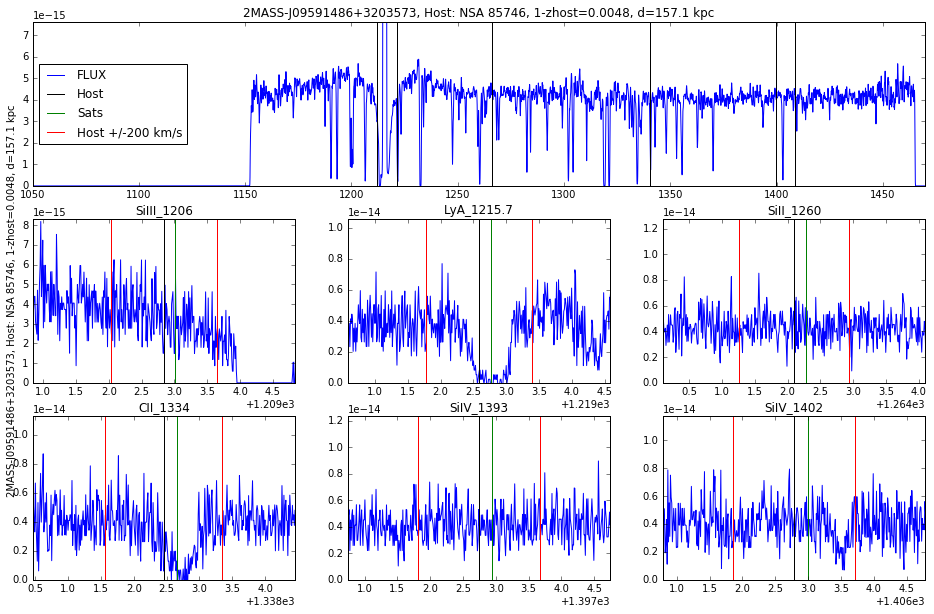

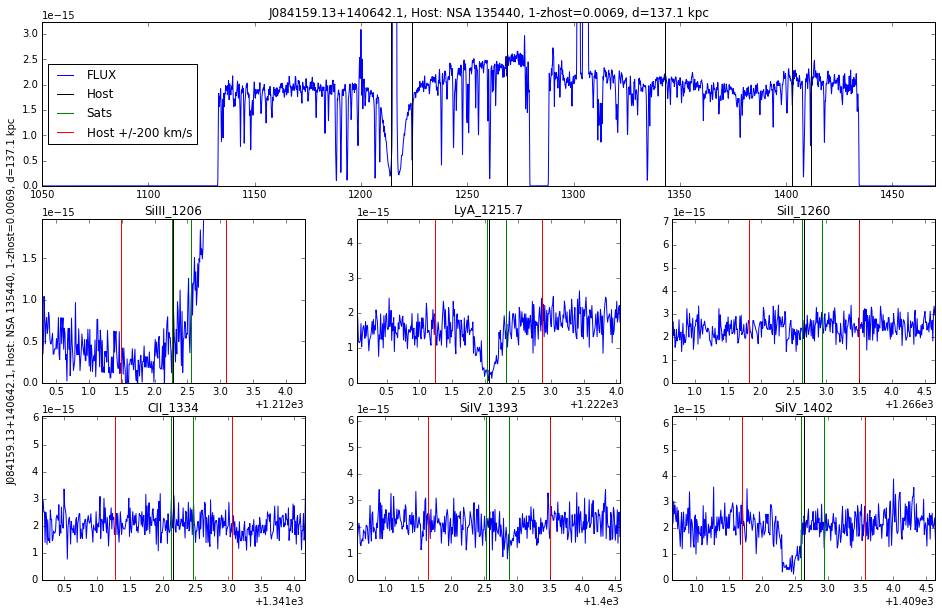

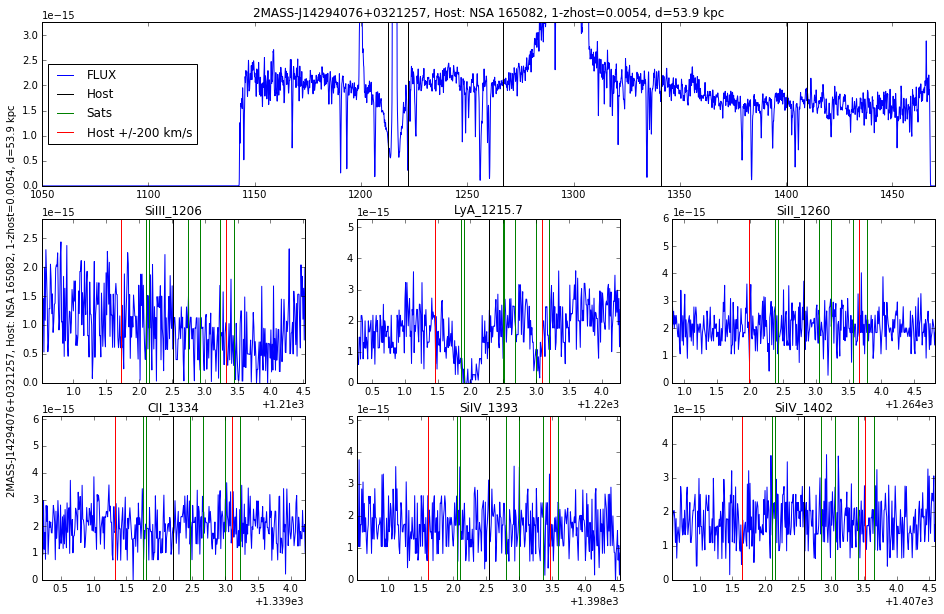

In [57]:
lines=['SiIII_1206', 'LyA_1215.7', 'SiII_1260', 'CII_1334', 'SiIV_1393', 'SiIV_1402']

smoothing = None #convolution.Box1DKernel(2.5)
smoothing1 = convolution.Gaussian1DKernel(10)

for row, spec_table in zip(hsla_to_check_tab, spec_tables):
    hostrow = tab_hosts[tab_hosts['NSAID']==row['SAGA_NSAID']][0]
    zhost = (hostrow['vhelio']*u.km/u.s/cnst.c).decompose()
    
    impact_p = hostrow['skycoord'].separation(row['skycoord']).radian*hostrow['distance']*1000*u.kpc
    
    sats = tab_sats[tab_sats['HOST_NSAID']==hostrow['NSAID']]
    zsats = sats['SPEC_Z']
    
    wl = spec_table['WAVE']
    if smoothing is None:
        fx = spec_table['FLUX']
    else:
        fx = convolution.convolve(spec_table['FLUX'], smoothing)
    
    plt.figure()
        
    ax1 = plt.subplot2grid((3,3), (0,0), colspan=3)
    if smoothing1 is None:
        fx1 = spec_table['FLUX']
    else:
        fx1 = convolution.convolve(spec_table['FLUX'], smoothing1)
        
    ax1.plot(wl, fx1)
    msg = '{0[Target Name]}, Host: NSA {1[NSAID]}, 1-zhost={2:.2}, d={3:.1f}'
    ax1.set_title(msg.format(row, hostrow, zhost, impact_p))
    ax1.set_xlim(1050, 1470)
    ax1.set_ylim(0, np.median(fx1)*2)
    
    
    
    for i, line in enumerate(lines):
        linenm, linewl = line.split('_')
        linewl = float(linewl)
        
        #plt.subplot(1, len(lines), i+1)
        plt.subplot(3, 3, i+4)
        plt.plot(wl, fx)
        plt.title(line)
        
        zhostwl = (1+zhost)*linewl
        wlrng = (zhostwl-2, zhostwl+2)
        plt.xlim(*wlrng)
        
        ax1.axvline(zhostwl, color='k')
        plt.axvline(zhostwl, color='k', label='Host')
        
        satlab = 'Sats'
        for zsat in zsats:
            plt.axvline((1+zsat)*linewl, c='g', label=satlab)
            satlab=None
            
        plt.axvline(zhostwl*(1+zhost+200*u.km/u.s/cnst.c)/(1+zhost), color='r', label='Host +/-200 km/s')
        plt.axvline(zhostwl*(1+zhost-200*u.km/u.s/cnst.c)/(1+zhost), color='r')
        plt.ylim(0, np.median(fx[(wlrng[0]<wl)&(wl<wlrng[1])])*3)
        
        
        if i==0:
            msg = '{0[Target Name]}, Host: NSA {1[NSAID]}, 1-zhost={2:.2}, d={3:.1f}'
            plt.ylabel(msg.format(row, hostrow, zhost, impact_p))
    #ax=plt.gca()#plt.legend(loc=0)
    handles, labels = plt.gca().get_legend_handles_labels()
    ax1.legend(handles, labels, loc='center left')